# Eddy Quenching

The notebook calculates vertical sections of an observable (e.g. density) and creates the figure for eddy-induced nitrate flux (chapter 3.3.1). The following figures are created in this notebook:
- Figure 3.15: Eddy-induced total nitrate flux

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts/')

import os

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from romstools.romsrun import RomsRun
from romstools.plot import plot_data
from romstools.utils import p, cache
from romstools.cmap import DIFF, DIFF_r, W2G, W2G_r, G2R, G2R_r, get_step_cmap

import scipy.signal as sig
import scipy.stats as stat

import cartopy.crs as ccrs

import warnings
from datetime import timedelta as tdelta

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.cm import get_cmap

## Load Data

In [2]:
def get_run(directory):
    # set uup run object
    meso = RomsRun('/nfs/kryo/work/maxsimon/data/'+directory+'/grid.nc')
    # add horizontal velocities
    meso.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_vel.nc')
    # add NO3 and density
    meso.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/climatologies/z_data-1d.nc', variables=['NO3_b', 'rho_b'])
    # add z locations
    meso.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_levels.nc')
    # add addtional data, i.e. vertical velocity
    meso.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_d_00*.nc')
    
    # additional grid data
    data = np.load('/nfs/kryo/work/maxsimon/data/'+directory+'/grid.npz', allow_pickle=True)
    meso.distance_map = data['distance_map']
    meso.distance_lines = data['distance_lines']
    meso.gruber_mask = data['gruber_mask']
    
    return meso

In [3]:
subm = get_run('pactcs15')
meso = get_run('pactcs30')

runs = {
    'pactcs15': subm,
    'pactcs30': meso
}

### Subdomain

In [4]:
# define subdomain
# this is not the same as the domain used for analysis because it is easier to stay in rho coordinates
vertical_sections = {
    'pactcs15': (slice(None, None), slice(525, 750)),
    'pactcs30': (slice(None, None), slice(210, 300))
}

/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin


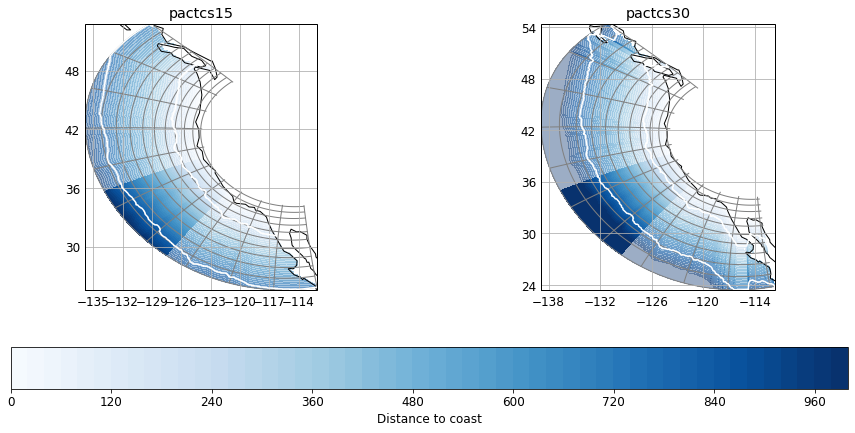

In [5]:
## show subdomains

fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})

plots = None
for i, name in enumerate(['pactcs15', 'pactcs30']):
    run = runs[name]
    _, plots = plot_data(run.grid, run.distance_map, highlight_subdomain=vertical_sections[name], ax=ax[i], vmin=0, vmax=1000, lon_name='lon_rho', lat_name='lat_rho', grid='both', as_contourfill=True, cmap='Blues', colorbar=False);
    for line in run.distance_lines:
        ax[i].plot(line[0], line[1], transform=ccrs.PlateCarree(), color='white')
    ax[i].set_title(name)

plt.colorbar(plots[1], ax=ax, orientation='horizontal', label='Distance to coast') 
plt.show()

## Utilities

In [6]:
def fix_nan_contour(func, distance_map, depth_values, data, **kwargs):
    # matplotlibs contour plots can not handle NaNs
    # this function fixes this
    xx, yy = None, None
    if len(distance_map.shape) == 2:
        print('WARNING :: DISTANCE MAP ON SECTION SLICE?')
        contour_x = np.mean(distance_map, axis=1)
        x_1 = np.argmin(np.isnan(contour_x[::-1]))
        xx, yy = np.meshgrid(contour_x[:-x_1], -depth_values)
    else:
        contour_x = distance_map
        xx, yy = np.meshgrid(contour_x, -depth_values)
    return func(xx[:data.shape[0]], yy[:data.shape[0]], data, **kwargs)


def interpolate_to_dist(data, name, num_interp_points, distance_map=None):
    # interpolate data on rho grid to a grid with distance to coast as the main axis.
    
    # get run and distance map
    run = runs[name]
    dmap = run.distance_map[vertical_sections[name]] if distance_map is None else distance_map
    
    # set up bins
    distances = np.linspace(0, 900, num_interp_points)
    # and result array
    result = np.empty((data.shape[0], distances.shape[0] - 1))
    centers = []
    
    # loop bins
    for dist_idx in range(distances.shape[0] - 1):
        # create mask
        mask = np.logical_and(
            dmap >= distances[dist_idx],
            dmap < distances[dist_idx + 1]
        )
        # calculate the value as average over all points belonging to the bin
        value = np.nanmean(
            data[:, mask], axis=1
        )
        # assign value to result
        result[:, dist_idx] = value
        # save the bin center for x coordinates
        centers.append(distances[dist_idx] + (distances[dist_idx + 1] - distances[dist_idx])/2)
    
    return np.array(centers), result


def interpolation_density(name, num_interp_points=100):
    # similar to interpolate_to_dist, but just return the number of points contributing to each bin
    
    # get run and distance map
    run = runs[name]
    dmap = run.distance_map[vertical_sections[name]]
    # set up bins
    distances=np.linspace(0, 900, num_interp_points)
    assert distances[-1] == 900
    # and result array
    result = np.empty((distances.shape[0] - 1, ))
    centers = []
    for dist_idx in range(distances.shape[0] - 1):
        # create mask
        mask = np.logical_and(
            dmap >= distances[dist_idx],
            dmap < distances[dist_idx + 1]
        )
        # assign number of points for this bin to result
        result[dist_idx] = np.count_nonzero(mask)
        # save the bin center for x coordinates
        centers.append(distances[dist_idx] + (distances[dist_idx + 1] - distances[dist_idx])/2)
    return np.array(centers), result

In [7]:
def plot_vertical(ax, name, values, interpolated=True, vmin=None, vmax=None, num_levels=30, num_levels_lines=10, cmap=None, colorbar_label='', distance_map=None, colorbar=True, contour_lines=None, show_ylabels=True):
    
    # get a run and the distance map (if not given)
    run = runs[name]
    dmap = run.distance_map[vertical_sections[name]] if distance_map is None else distance_map
    
    ax.set_xlim(900, 0)
    # set levels as a number of levels or as a linear spacing between vmin and vmax
    levels = num_levels if vmin is None or vmax is None else np.linspace(vmin, vmax, num_levels)
    # plot data
    cax = fix_nan_contour(ax.contourf, dmap, run.z_level, values, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap, extend='both')
    
    # add contour lines
    if num_levels_lines > 0:
        c = contour_lines if contour_lines is not None else values
        cax2 = fix_nan_contour(ax.contour, dmap, run.z_level, c, levels=num_levels_lines, colors='k', extend='both')
        # ... with labels
        ax.clabel(cax2, cax2.levels, inline=True, fontsize=10)
    
    # labels
    ax.set_xlabel('Distance to coast [km]')
    if show_ylabels:
        ax.set_ylabel('Depth [m]')
    
    # colorbar...
    ticks = None  # if vmin and vmax is provided, set up ticks for colorbar manually
    if vmin is not None and vmax is not None:
        ticks = np.linspace(vmin, vmax, 11)
    if colorbar:
        cbar = plt.colorbar(cax, ticks=ticks, label=colorbar_label)
        
    return cax

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less


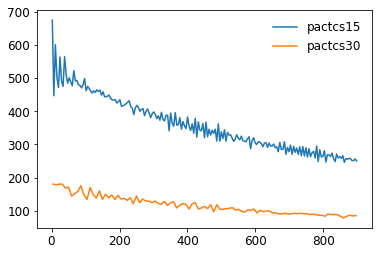

In [8]:
## define to how many points the vertical section is interpolated to
interp_points = {
    'pactcs15': 200,
    'pactcs30': 100
}

# visualisation of the number of points contributing to each bin
fig, ax = plt.subplots(1, 1)
for scale in ('pactcs15', 'pactcs30'):
    ax.plot(*interpolation_density(scale, interp_points[scale]), label=scale)
ax.legend(frameon=False)
plt.show()

## Density

In [9]:
def vert_var(name, var, time_slice=slice(None, None)):
    # get the mean value of a variable var within the domain
    run = runs[name]
    section_slice = vertical_sections[name]
    return run[var].isel(eta_rho=section_slice[0], xi_rho=section_slice[1], doy=time_slice).mean(dim=['doy']).values

In [10]:
# get rho data
rho = {
    name: cache('data-cache/finalRhoFull-'+name, p(vert_var, name, 'rho_b'))[0] for name in runs
}

# interpolate rho data to vertical distances
rho_interp = {
    scale: interpolate_to_dist(rho[scale], scale, interp_points[scale]) for scale in rho
}

Load cache
Load cache


/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


In [11]:
# interpolate pactcs15 also to pactcs30 to compare
rho_interp_15to30 = interpolate_to_dist(rho['pactcs15'], 'pactcs15', interp_points['pactcs30'])

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


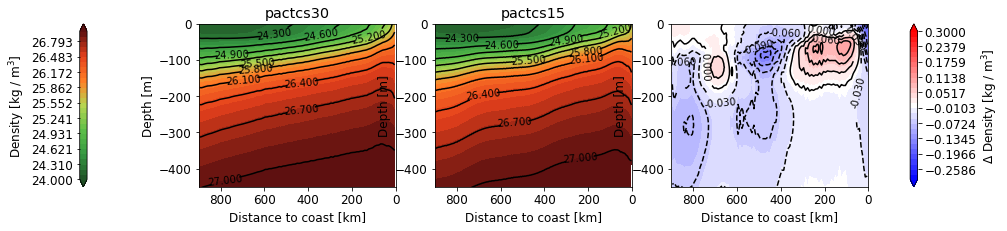

In [12]:
# plot the vertical sections of the density next each other

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
cax = None
for i, scale in enumerate(('pactcs30', 'pactcs15')):
    # plot data
    cax = plot_vertical(ax[i], scale, rho_interp[scale][1], vmin=24, vmax=27, cmap=G2R, distance_map=rho_interp[scale][0], colorbar=False)
    # set title
    ax[i].set_title(scale)
    ax[i].set_ylim(-450, 0)
    
# plot the difference between pactcs15 and pactcs30
caxDiff = plot_vertical(ax[2], 'pactcs30', rho_interp_15to30[1] - rho_interp['pactcs30'][1], vmin=-.3, vmax=.3, cmap='bwr', distance_map=rho_interp_15to30[0], colorbar=False)
ax[2].set_ylim(-450, 0)

# colorbars
plt.colorbar(cax, ax=ax, label='Density [kg / m$^{3}$]', location='left')
plt.colorbar(caxDiff, ax=ax, label='$\\Delta$ Density [kg / m$^{3}$]', location='right')

plt.show()

## Total nitrate flux

In [13]:
def calc_nitrate_flux(name, direction):
    
    # get section slice and run
    section_slice = vertical_sections[name]
    run = runs[name]
    
    # direction should be hor for horizontal component of flux or vert for vertical component
    assert direction in ('hor', 'vert')
    
    res = None
    res_counter = 0
    
    # use v as it is more or less perpendicular to the coast
    vel_name = 'w' if direction == 'vert' else 'v'
    
    # open full dataset
    ds = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+name+'/nitro/'+vel_name+'_prime_3.nc')
    # vertical velocity. TODO: the name might be different!
    ds_w = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+name+'/nitro/'+vel_name+'_prime_3.nc')[vel_name+'_p']
    # nitrate. TODO: the name might be different!
    ds_n = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+name+'/nitro/total_prime_3.nc').__xarray_dataarray_variable__
    
    # time objects
    times = ds.time.values[:ds_w.shape[0]]
    
    # loop times
    for t_idx, t_obj in enumerate(times):
        print('Processing', t_obj, end='\r')
        doy = t_obj.dayofyr - 1
        
        # skip first two years
        if t_obj.year < 3:
            continue
        
        # get vertical velocity...
        data1 = ds_w.isel(time=t_idx, eta_rho=section_slice[0], xi_rho=section_slice[1]).values
        # ... and total nitrate
        data2 = ds_n.isel(time=t_idx, eta_rho=section_slice[0], xi_rho=section_slice[1]).values
        # multiply
        data = data1 * data2
        
        # add to result if it exists
        if res is None:
            res = data
        else:
            res = np.nansum((res, data), axis=0)
        
        res_counter += 1
    
    # return normalized (averaged) data.
    return res/res_counter

In [14]:
# get vertical component of Total nitrate flux
NO3_flux_vert = cache('data-cache/fullallNFluxVert-pactcs30', p(calc_nitrate_flux, 'pactcs30', 'vert'))[0]
# interpolate vertical component to distance to coast
NO3_flux_vert_interp = interpolate_to_dist(NO3_flux_vert, 'pactcs30', interp_points['pactcs30'])

# get horizontal component of Total nitrate flux
NO3_flux_hor = cache('data-cache/fullallNFluxHor-pactcs30', p(calc_nitrate_flux, 'pactcs30', 'hor'))[0]
# interpolate horizontal component to distance to coast
NO3_flux_hor_interp = interpolate_to_dist(NO3_flux_hor, 'pactcs30', interp_points['pactcs30'])

Load cache


/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


Load cache


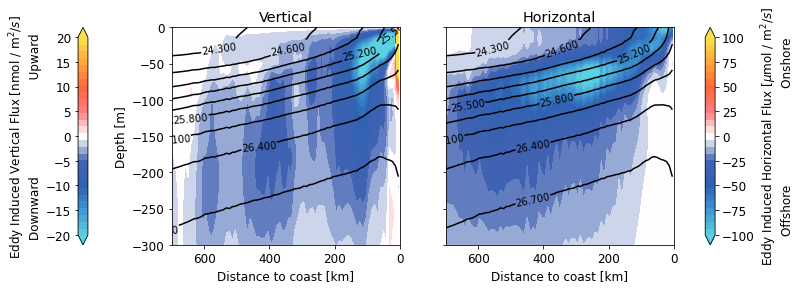

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# plot vertical component
cax1 = plot_vertical(ax[0], 'pactcs30', NO3_flux_vert_interp[1] * 1e6, vmin=-20, vmax=20, cmap=DIFF_r, distance_map=NO3_flux_vert_interp[0], colorbar=False, contour_lines=rho_interp['pactcs30'][1])
# title and maximum extent
ax[0].set_ylim(-300, 0)
ax[0].set_xlim(700, 0)
ax[0].set_title('Vertical')

# plot horizontal component
cax2 = plot_vertical(ax[1], 'pactcs30', NO3_flux_hor_interp[1] * 1e3, vmin=-100, vmax=100, cmap=DIFF_r, distance_map=NO3_flux_hor_interp[0], colorbar=False, contour_lines=rho_interp['pactcs30'][1])
# title and maximum extent
ax[1].set_ylim(-300, 0)
ax[1].set_xlim(700, 0)
ax[1].set_title('Horizontal')
# disable y label as shared with first panel
ax[1].set_ylabel('')

# colorbars
plt.colorbar(cax1, ax=ax, label='Eddy Induced Vertical Flux [nmol / m$^{2} / s$]\nDownward                         Upward', location='left', ticks=[-20, -15, -10, -5, 0, 5, 10, 15, 20])
plt.colorbar(cax2, ax=ax, label='Eddy Induced Horizontal Flux [$\mu$mol / m$^{2} / s$]\nOffshore                         Onshore', location='right', ticks=[-100, -75, -50, -25, 0, 25, 50, 75, 100])

plt.savefig('figures/result_eddy_quenching.pdf')
plt.show()